In [ ]:
! pip install transformers "datasets>=1.17.0" tensorboard --upgrade
! pip install transformers pytorch-lightning --quiet
! sudo apt -qq install git-lfs
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, UnidentifiedImageError
from pathlib import Path
import torch
import glob
import pytorch_lightning as pl
from huggingface_hub import HfApi, Repository
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchmetrics import Accuracy
from transformers import ViTFeatureExtractor, ViTForImageClassification
from pytorch_lightning.callbacks import ModelCheckpoint

     |████████████████████████████████| 3.4 MB 7.6 MB/s 
     |████████████████████████████████| 306 kB 59.9 MB/s 
     |████████████████████████████████| 67 kB 5.5 MB/s 
     |████████████████████████████████| 243 kB 64.8 MB/s 
     |████████████████████████████████| 133 kB 55.3 MB/s 
     |████████████████████████████████| 1.1 MB 45.6 MB/s 
     |████████████████████████████████| 895 kB 47.5 MB/s 
     |████████████████████████████████| 3.3 MB 55.0 MB/s 
     |████████████████████████████████| 596 kB 65.1 MB/s 
     |████████████████████████████████| 271 kB 58.4 MB/s 
     |████████████████████████████████| 144 kB 62.1 MB/s 
     |████████████████████████████████| 160 kB 50.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 526 kB 8.3 MB/s 
     |████████████████████████████████| 829 kB 43.3 MB/s 
     |████████████████████████████████| 396

In [ ]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
model_id = "google/vit-base-patch16-224-in21k"

In [ ]:
import os
import datasets

def create_image_folder_dataset(root_path):
  """creates `Dataset` from image folder structure"""
  
  # get class names by folders names
  _CLASS_NAMES= os.listdir(root_path)
  # defines `datasets` features`
  features=datasets.Features({
                      "img": datasets.Image(),
                      "label": datasets.features.ClassLabel(names=_CLASS_NAMES),
                  })
  # temp list holding datapoints for creation
  img_data_files=[]
  label_data_files=[]
  # load images into list for creation
  for img_class in os.listdir(root_path):
    for img in os.listdir(os.path.join(root_path,img_class)):
      path_=os.path.join(root_path,img_class,img)
      img_data_files.append(path_)
      label_data_files.append(img_class)
  # create dataset
  ds = datasets.Dataset.from_dict({"img":img_data_files,"label":label_data_files},features=features)
  return ds

In [ ]:
root_path = "/content/drive/MyDrive/Thesis/Names100/Dataset/Extracted_Folder/Names100Dataset/ClassWise_10/"

Name100 = create_image_folder_dataset(root_path)

In [ ]:
img_class_labels = Name100.features["label"].names

In [ ]:
print(img_class_labels)

['Amanda', 'Brian', 'Aaron', 'Jamie', 'Brandon', 'Abby', 'Andrea', 'Anthony', 'Dylan', 'Angela']


In [ ]:
eurosat_ds = Name100

from transformers import ViTFeatureExtractor
from tensorflow import keras 
from tensorflow.keras import layers

feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)

# learn more about data augmentation here: https://www.tensorflow.org/tutorials/images/data_augmentation
data_augmentation = keras.Sequential(
    [
        layers.Resizing(feature_extractor.size, feature_extractor.size),
        layers.Rescaling(1./255),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# use keras image data augementation processing
def augmentation(examples):
    # print(examples["img"])
    examples["pixel_values"] = [data_augmentation(image) for image in examples["img"]]
    return examples


# basic processing (only resizing)
def process(examples):
    examples.update(feature_extractor(examples['img'], ))
    return examples

# we are also renaming our label col to labels to use `.to_tf_dataset` later
eurosat_ds = eurosat_ds.rename_column("label", "labels")

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
processed_dataset = eurosat_ds.map(process, batched=True)
processed_dataset

# # augmenting dataset takes a lot of time
# processed_dataset = eurosat_ds.map(augmentation, batched=True)

  0%|          | 0/8 [00:00<?, ?ba/s]

Dataset({
    features: ['img', 'labels', 'pixel_values'],
    num_rows: 8000
})

In [ ]:
# test size will be x% of train dataset
test_size=.20

processed_dataset = processed_dataset.shuffle().train_test_split(test_size=test_size)

In [ ]:
from huggingface_hub import HfFolder
import tensorflow as tf

id2label = {str(i): label for i, label in enumerate(img_class_labels)}
label2id = {v: k for k, v in id2label.items()}

num_train_epochs = 5
train_batch_size = 32
eval_batch_size = 32
learning_rate = 3e-5
weight_decay_rate=0.01
num_warmup_steps=0
output_dir=model_id.split("/")[1]
hub_token = HfFolder.get_token() # or your token directly "hf_xxx"
hub_model_id = f'{model_id.split("/")[1]}-euroSat'
fp16=True

# Train in mixed-precision float16
# Comment this line out if you're using a GPU that will not benefit from this
if fp16:
  tf.keras.mixed_precision.set_global_policy("mixed_float16")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
from transformers import DefaultDataCollator

# Data collator that will dynamically pad the inputs received, as well as the labels.
data_collator = DefaultDataCollator(return_tensors="tf")

# converting our train dataset to tf.data.Dataset
tf_train_dataset = processed_dataset["train"].to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   shuffle=True,
   batch_size=train_batch_size,
   collate_fn=data_collator)

# converting our test dataset to tf.data.Dataset
tf_eval_dataset = processed_dataset["test"].to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   shuffle=False,
   batch_size=eval_batch_size,
   collate_fn=data_collator)

In [ ]:
from transformers import TFViTForImageClassification, create_optimizer
import tensorflow as tf

# create optimizer wight weigh decay
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,
)

# load pre-trained ViT model
model = TFViTForImageClassification.from_pretrained(
    model_id,
    num_labels=len(img_class_labels),
    id2label=id2label,
    label2id=label2id,
)

# define loss
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# define metrics 
metrics=[
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
]

# compile model
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics
              )

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/kernel:0', 'vit/pooler/dense/bias:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# alternatively create Image Classification model using Keras Layer and ViTModel 
# here you can also add the processing layers of keras

import tensorflow as tf
from transformers import TFViTModel

base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

# inputs
pixel_values = tf.keras.layers.Input(shape=(3,224,224), name='pixel_values', dtype='float32')

# model layer
vit = base_model.vit(pixel_values)[0]
classifier = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(vit[:, 0, :])

# model
keras_model = tf.keras.Model(inputs=pixel_values, outputs=classifier)

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [ ]:
import os
from transformers.keras_callbacks import PushToHubCallback
from tensorflow.keras.callbacks import TensorBoard as TensorboardCallback, EarlyStopping

callbacks=[]

callbacks.append(TensorboardCallback(log_dir=os.path.join(output_dir,"logs")))
callbacks.append(EarlyStopping(monitor="val_accuracy",patience=1))
if hub_token:
  callbacks.append(PushToHubCallback(output_dir=output_dir,
                                     hub_model_id=hub_model_id,
                                     hub_token=hub_token))

In [ ]:
train_results = model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    callbacks=callbacks,
    epochs=num_train_epochs,
)

Epoch 1/5
200/200 [==============================] - 2054s 10s/step - loss: 2.1064 - accuracy: 0.2261 - top-3-accuracy: 0.5552 - val_loss: 1.9989 - val_accuracy: 0.2519 - val_top-3-accuracy: 0.5981
Epoch 2/5
200/200 [==============================] - 1990s 10s/step - loss: 1.9089 - accuracy: 0.3022 - top-3-accuracy: 0.6450 - val_loss: 1.9831 - val_accuracy: 0.2606 - val_top-3-accuracy: 0.5944
Epoch 3/5
200/200 [==============================] - 1980s 10s/step - loss: 1.7979 - accuracy: 0.3542 - top-3-accuracy: 0.7013 - val_loss: 1.9359 - val_accuracy: 0.2612 - val_top-3-accuracy: 0.6181
Epoch 4/5
200/200 [==============================] - 2038s 10s/step - loss: 1.6972 - accuracy: 0.4095 - top-3-accuracy: 0.7492 - val_loss: 1.9371 - val_accuracy: 0.2650 - val_top-3-accuracy: 0.6150
Epoch 5/5
200/200 [==============================] - 1971s 10s/step - loss: 1.6184 - accuracy: 0.4669 - top-3-accuracy: 0.7839 - val_loss: 1.9444 - val_accuracy: 0.2575 - val_top-3-accuracy: 0.6169


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
ypred = model.predict(tf_eval_dataset)

In [ ]:
ypred = ypred.logits.argmax(-1)

In [ ]:
true_categories = tf.concat([y for x, y in tf_eval_dataset], axis=0)

In [ ]:
true_categories = np.array(true_categories)

              precision    recall  f1-score   support

           0       0.23      0.43      0.30       144
           1       0.26      0.46      0.33       161
           2       0.19      0.08      0.11       178
           3       0.21      0.03      0.06       147
           4       0.19      0.17      0.18       155
           5       0.33      0.46      0.38       151
           6       0.10      0.02      0.03       166
           7       0.24      0.22      0.23       172
           8       0.25      0.33      0.29       163
           9       0.33      0.40      0.36       163

    accuracy                           0.26      1600
   macro avg       0.23      0.26      0.23      1600
weighted avg       0.23      0.26      0.23      1600



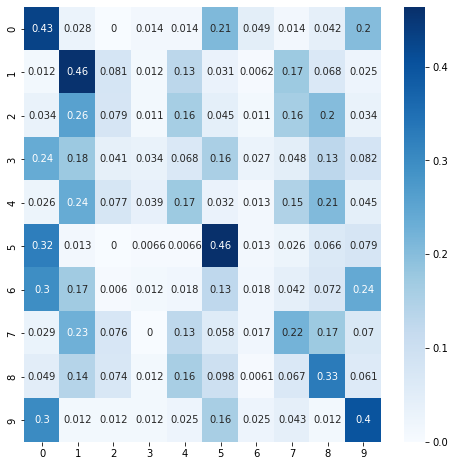

In [ ]:
confusionmatrix = confusion_matrix(true_categories, ypred, normalize='true')
plt.figure(figsize = (8, 8))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_categories, ypred))